<font face="Calibri" size="2"> <i>SBAE - Notebook Series - Part I, version 0.3,  May 2023. Andreas Vollrath, Daniel Wiell, Javier Garcia-Perez, Laura D'Aietti, Remi D'Annunzio - UN-Food and Agricultural Organization, Rome</i>
</font>

![title](images/header.png)

# I - Pre-analysis
### Forest and Deforestation statistics, sample size and error calculation & simulation 
-------


This notebook provides code and functions for the extraction of some basic information on forest statistics for a give area of interest as well as sample size and error calculations. It is structured in the following parts:
    
1. Forest area and deforestation statistics according to Global Forest Change product ([Hansen et al 2013](https://10.1126/science.1244693))
2. Theoretical sample size and error calculation according to Cochran for capturing deforestation events
3. Simulation of sampling error based on Global Forest Change product

Most of the data and functionality is coming from [Google Earth Engine](https://earthengine.google.com), for which you will need a valid account. It is possible to freely sign up [here](https://code.earthengine.google.com/register).

## Introduction to eSBAE notebooks (first time users, read carefully)

The E-SBAE notebooks are a series of Jupyter notebooks intended to streamline the process of creating activity data for measurement, reporting, and verification of REDD+ and other carbon standards. 

E-SBAE is mainly based on the sampling-handler python library that provides all the necessary underlying functionality. While the notebooks take away the heavy burden of coding each single element, you will only need to declare some basic input variables that define your custom needs. This means you **do not need** to be a an experienced python programmer, but a basic understanding does help.

You will notice that the structure of each notebook is fairly similar, with only the parameter settings adapting for the current step. You can also use individual parts for specific purposes, but going through each of the notebooks consecutively ensures the best way for a smooth execution of the entire process.

There are two elements that tie the outputs of each notebook together - the ***Project Name*** and an underlying ***configuration file***. This not only eases the interaction but also ensures transparency, reproducibility, and interaction between different steps/notebooks. 

In [1]:
import ee 
# initialize EE    
try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

from sampling_handler import SampleSize

/usr/local/share/jupyter/kernels/venv-eSBAE_notebooks/venv/lib/python3.8/site-packages/bfast/__init__.py:10: UserWarning: cupy is not available in this environment, GPU fonctionnalities won't be available
  warn("cupy is not available in this environment, GPU fonctionnalities won't be available")


### 1 - Basic Parameter Settings

In the following cell you will define some of the key parameters to create the subsequent forest statistics. 

1. Project Name: This will not only give your work a name, but it also defines the output folder within the module_results/esbae (if you are on SEPAL), as well as a directory within your Earth Engine assets. **NOTE** that it shall not contain any space.

2. Area of Interest (AOI): Your AOI defines the spatial extent for which the data will be generated and analysed. It can come in different formats, such as a (filtered) Earth Engine feature collection, an OGR compatible geospatial data format (e.g. Shapefile, Geopackage, KML, GeoJSON), or a geopandas GeoDataFrame opject.

3. Start and end year will define the temporal extent, for which deforestation areas are extracted from the GFC product. This area will ultimately be used to determine the sampling size based on Cochran's equation.

4. Tree cover and mmu determine by which threshholds the GFC product will be filtered in order to consider a (set of) pixels as forest. Values are set in percentage and hectare.

#### You can check the country name from the FAO GAUL dataset in GEE using this script and copy your country name
var countries = ee.FeatureCollection("FAO/GAUL/2015/level0");
var names = countries.aggregate_array('ADM0_NAME');

var keys = ee.Dictionary(names).keys();

print(keys);

var values = ee.Dictionary(names).values();

print(values.sort());

In [11]:
# Here goes your project's name (without spaces)
project_name = 'sepredd'

# Area of Interest (various options, e.g. shapefile, geodataframe, ee FeatureCollection)
# Example uses a filtered Earth Egnine Feature Collection
country = "C�te d'Ivoire"
gaul = ee.FeatureCollection("FAO/GAUL/2015/level1")
aoi = gaul.filter(ee.Filter.eq("ADM0_NAME", country)).union()

# envisaged FREL/change assessment period (years are inclusive)
start_year = 2016       # YYYY format
end_year = 2022         # YYYY format

# forest definition
tree_cover = 10         # in percentage
mmu = 0.5               # in hectare 

### 2 - initializing the Sample Size class instance

This is to update the configuration file, nothing needs to be changed here.

In [12]:
esbae = SampleSize(
    project_name=project_name,
    aoi=aoi,
    start=start_year,
    end=end_year,
    tree_cover=tree_cover,
    mmu=mmu
)

INFO: Using existing project directory at /home/sepal-user/module_results/esbae/sepredd
INFO: Using existent config file from project directory /home/sepal-user/module_results/esbae/sepredd


It seems a different AOI is already defined within your configuration. Do you want to overwrite it (yes/no) yes


### 3 - Extract Forest Area and Annual Deforestation 

#### 3.1 Using Global Forest Change product

Using the following routine, Forest Area will be determined according to the start year and the tree cover percentage. Tree cover loss statistics are taken from the period that spans between start and end year.

INFO: Verifying parameter settings...
INFO: Extracting areas of forest and tree cover loss from Hansen's Global Forest Change product. This may take a moment...


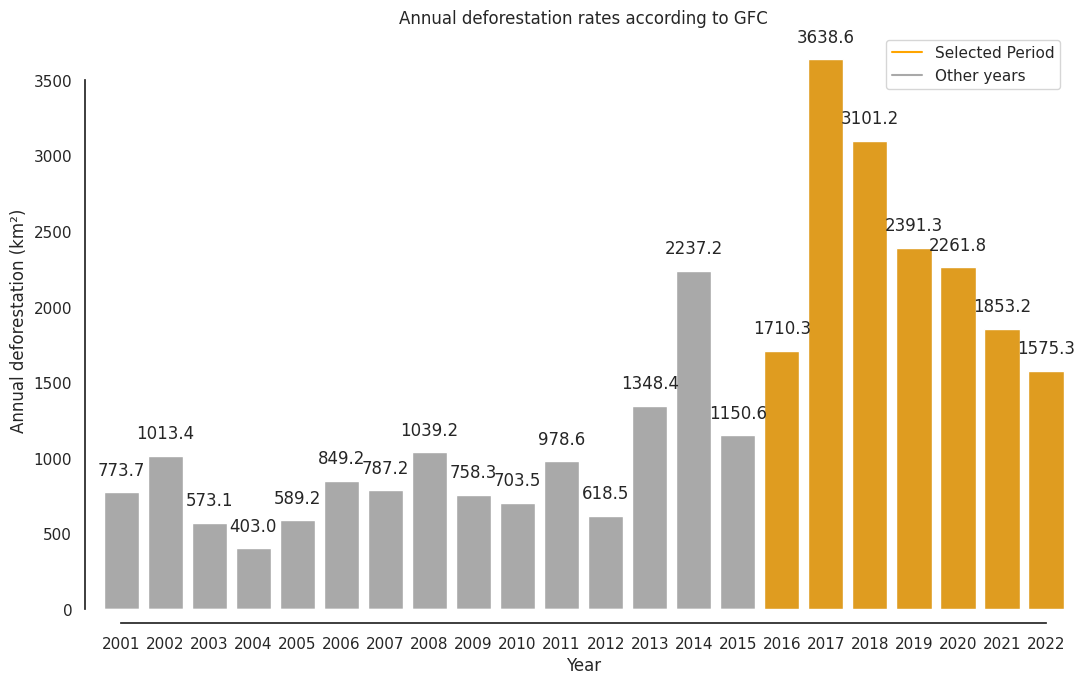

In [13]:
# get area statistics from Hansen's GFC data from Google Earth Engine
esbae.gfc_areas(save_figure=True)

### 4. Sample Size Calculation according to Cochran

By providing a target error and confidence interval, the minimum sample size is calculated based on the forest area statistics created above. The calculation is done both, for forest area as well as forest change, based on the Cochran formula for sample size ([Cochran 1963](https://onlinelibrary.wiley.com/doi/10.1002/zamm.19630431039)).

#### 4.1 - Calculate the margin of error and grid spacing

INFO: Verifying parameter settings...
INFO: Verifying parameter settings...


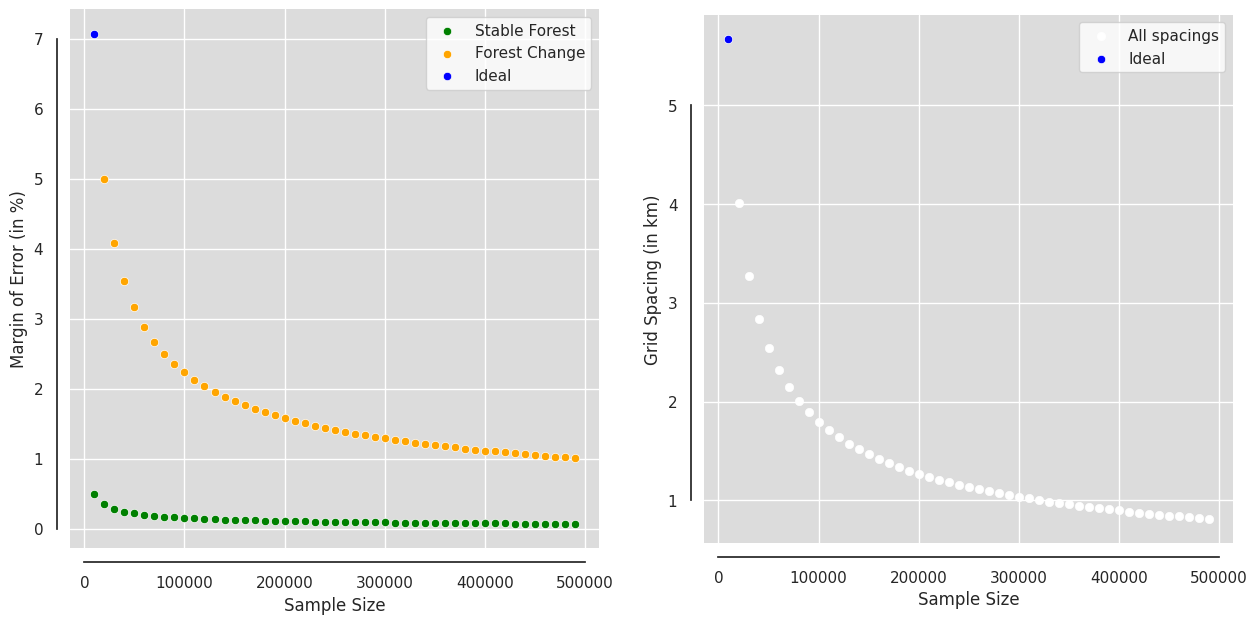

In [14]:
esbae.target_error = 10     # in percentage
esbae.confidence = 90    # in percentage

esbae.minimum_sample_size(save_figure=True)

### 5 - Simulation of sampling errors (bias and uncertainty)

INFO: Verifying parameter settings...
INFO: Running the sampling error simulation. This can take a while...


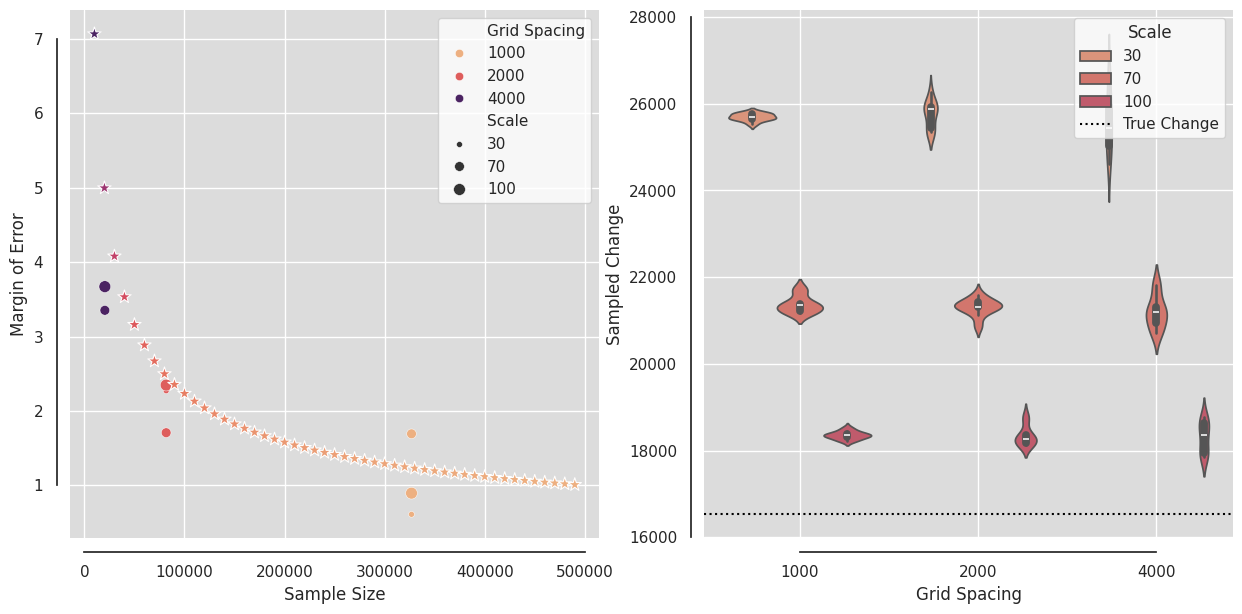

In [15]:
esbae.spacings =    [1000, 2000, 4000]      # grid spacings to simulate
esbae.scales =      [30, 70, 100]            # mmus to simulate
esbae.runs =        10                           # nr of times a each simulation is run
esbae.random_seed = 42                           # a random seed for reproducability

esbae.simulated_sampling_error(save_figure=True)